In [1]:
%pylab inline
import datajoint as dj
import numpy as np

Populating the interactive namespace from numpy and matplotlib
DataJoint 0.4.6 (December 22, 2016)
Loading local settings from dj_local_conf.json


## create a database 

In [13]:
schema = dj.schema('examples_generic', locals())

## define tables

In [4]:
@schema
class Experiment(dj.Manual):
    definition = """ # A simple experiment.
    experiment : int
    ----
    """

    
@schema
class Set(dj.Imported):
    definition = """
    # A set of datapoints
    -> Experiment
    -----
    """ 

    class DataPoint(dj.Part):
        definition = """
        # Collected data.
        -> Set
        datapoint : int 
        -----
        x : float
        y : float 
        """
        
    def _make_tuples(self, key):
        n = 10
        mu = 0
        sigma = .1
        
        self.insert1(key)
        self.DataPoint().insert((
            dict(key, 
                 datapoint=i, 
                 x=i + np.random.normal(mu, sigma), 
                 y=2*i + np.random.normal(mu, sigma)) 
                for i in range(n)))

  



## plot entity-relationship diagram

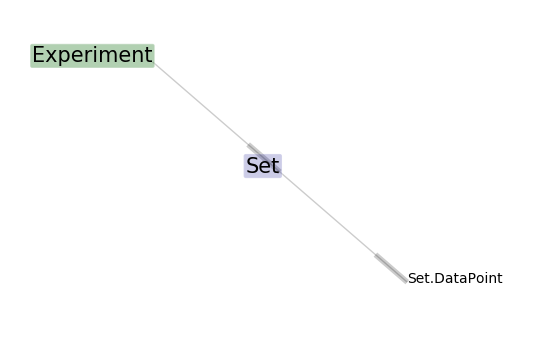

In [5]:
dj.ERD(schema).draw()

In [6]:
## populate data
Experiment().insert(([1],[2],[3]), skip_duplicates=True)
Set().populate()

In [7]:
print(Set.DataPoint())

*experiment    *datapoint    x             y            
+------------+ +-----------+ +-----------+ +-----------+
1              0             0.0238646     0.0577225    
1              1             1.06731       2.02639      
1              2             1.89245       3.91843      
1              3             3.22626       5.99959      
1              4             3.98412       8.02374      
1              5             5.05867       9.77257      
1              6             5.93836       12.0243      
   ...
 (30 tuples)



## analysis

In [8]:

@schema
class LinearModel(dj.Computed):
    definition = """
    # fits line a DataCollection. y=mx+b form
    -> Set
    -----
    m : float     # Slope
    b : float     # intercept
    """    
    def _make_tuples(self, key):
        X, Y = (Set.DataPoint() & key).fetch['x', 'y']          
        X = np.stack([X, np.ones_like(X)], axis=-1)
        m, b = np.linalg.lstsq(X, Y)[0]        
        self.insert1(dict(key, m=m, b=b))
    
    
@schema
class Stats(dj.Computed):
    definition = """
    # Computes Mean Square Error and R2 for a particular Model
    -> LinearModel
    -----
    mse : float         # The MSE value.
    r2  : float         # R-squared of linear fit
    """    
    def _make_tuples(self, key):
        X, Y =  (Set.DataPoint() & key).fetch['x', 'y']
        m, b = (LinearModel() & key).fetch1['m', 'b']
        yCalc = X*m + b
        self.insert1(
            dict(key, 
                 mse=((Y - yCalc) ** 2).mean(axis=0), 
                 r2=1-np.sum((Y - yCalc)**2)/np.sum((Y - np.mean(Y))**2)))

        
#schema.spawn_missing_classes()

## plot entity-relationship diagram

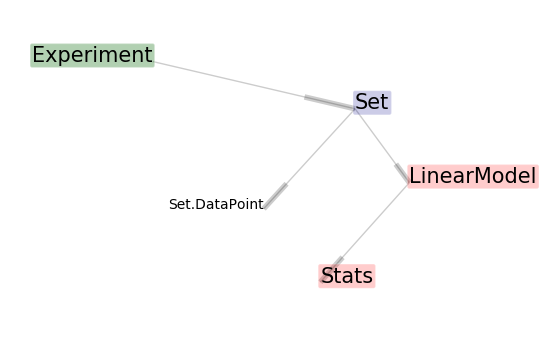

In [12]:
dj.ERD(schema).draw()

## populate data

In [9]:
# Build the models and compute the stats

LinearModel().populate()
Stats().populate()

In [10]:
Set.DataPoint()

experiment,datapoint,x,y
1,0,-0.142984,0.0652298
1,1,0.961803,2.18967
1,2,2.05107,3.77525
1,3,3.20669,5.87526
1,4,3.9708,7.86246
1,5,5.00483,9.97459
1,6,6.00967,11.808


In [7]:
print(Stats())

experiment,mse,r2
1,0.0761928,0.997697
2,0.0409618,0.998756
3,0.019036,0.999423


## Drop all tables 

In [16]:
Experiment().drop()

`robby1_ex1`.`experiment` (3 tuples)
`robby1_ex1`.`_set` (3 tuples)
`robby1_ex1`.`_set__data_point` (30 tuples)
`robby1_ex1`.`__linear_model` (3 tuples)
`robby1_ex1`.`__stats` (3 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.
